## Testing two classifiers, an SVM and a neural network, to distinguish between low- and high-T data.

I load the Network class that's in another notebook.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import tensorflow as tf 
import h5py

%run Network.ipynb

import warnings
warnings.filterwarnings('ignore')

In [3]:
f=h5py.File("PCA_params.hdf5","r")
P=f['Parameters']
T=f['Time']
N=len(T)

P=np.array(P)
T=np.array(T)
L=np.where(T<=0.35,1,0)

f.close()

The data set is divided into test set, validation set (for the net) and a training set.

In [4]:
P_tr_val,P_test,L_tr_val,L_test=train_test_split(P,L,test_size=0.1)
P_train,P_val,L_train,L_val=train_test_split(P_tr_val,L_tr_val,test_size=0.2)

### Neural network

The neural network will have only one hidden layer with 50 cells. All of them are connected. Number of cells in the hidden layer and the learning rate were chosen after tweaking and testing the network a couple times. The network is also saved to a file.

In [4]:
layers=[P.shape[1],50,2]
batch_size=50
n_epochs=20
learning_rate=0.0001
fl_name='time_classifier'

We use sigmoid function as the activation function and stochastic gradient descent with a batch size of 50.

In [5]:
net=Network(layers,batch_size,fl_name)
net.create_network(learning_rate,activ="SIG")
net.train(P_train,L_train,P_val,L_val,n_epochs,save_model=True)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
0 Train accuracy: 0.3429663 Val accuracy: 0.36050156
1 Train accuracy: 0.52076805 Val accuracy: 0.5481975
2 Train accuracy: 0.6628135 Val accuracy: 0.6775078
3 Train accuracy: 0.77037615 Val accuracy: 0.7754702
4 Train accuracy: 0.85109717 Val accuracy: 0.84757054
5 Train accuracy: 0.906348 Val accuracy: 0.9020376
6 Train accuracy: 0.9363245 Val accuracy: 0.92789966
7 Train accuracy: 0.9522923 Val accuracy: 0.947884
8 Train accuracy: 0.9588558 Val accuracy: 0.9541536
9 Train accuracy: 0.9621865 Val accuracy: 0.95689654
10 Train accuracy: 0.9633621 Val accuracy: 0.9576802
11 Train accuracy: 0.9641458 Val accuracy: 0.9588558
12

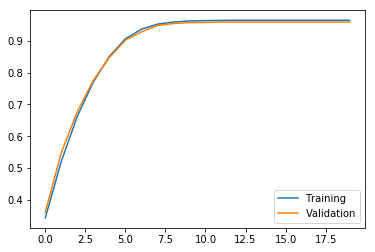

In [6]:
net.plot_error()

In [7]:
NN_test_score=net.score(P_test,L_test)
print('Test score is {:.4f}'.format(NN_test_score))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./time_classifier.ckpt
Test score is 0.9669


### Support Vector Machine classifier

The parameters for SVM classifier were also chosen after some optimization (grid search was performed). This SVM uses an rbf kernel. Gamma below 1, and C of about 4 both point towards lowering bias of the classification. 

In [5]:
clf = SVC(class_weight="balanced",gamma=0.265,tol=0.0001,C=4.1875)
clf.fit(P_train,L_train) 

SVC(C=4.1875, class_weight='balanced', gamma=0.265, tol=0.0001)

In [6]:
SVC_test_score=clf.score(P_test,L_test)
SVC_train_score=clf.score(P_train,L_train)
print('Test score is {:.4f}'.format(SVC_test_score))
print('Training score is {:.4f}'.format(SVC_train_score))

Test score is 0.9690
Training score is 0.9896


Both methods seem to yield almost identical result on the test set, even though SVM seems to slightly overfit to the training set.

### SVM classifier performance

In [33]:
Prediction_test=clf.predict(P_test)
Prediction_train=clf.predict(P_tr_val)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
L_real=np.concatenate((L_test,L_tr_val))
L_pred=np.concatenate((Prediction_test,Prediction_train))

In [35]:
df=pd.DataFrame(data={"Real":L_real,"Prediction":L_pred})

Confusion Matrix

In [36]:
df_grouped=pd.crosstab(df.Real,df.Prediction)
df_grouped

Prediction,0,1
Real,,
0,13463,201
1,50,464


We can now look at recall, precision and accuracy to see how good the predictions are. Here, we will assume that class "1" is the positive class, and so for example "specificity" will be equivalent to "recall" for class "0".

In [37]:
TP=df_grouped[1][1]
TN=df_grouped[0][0]
FP=df_grouped[1][0]
FN=df_grouped[0][1]

In [38]:
RC0=TN/(TN+FP)
RC1=TP/(TP+FN)
PR0=TN/(TN+FN)
PR1=TP/(TP+FP)
ACC=(TN+TP)/(TN+TP+FP+FN)
FNR=FN/(TP+FN)
FPR=FN/(TN+FP)

In [39]:
print('Recall for class 0 (True Negative Rate): {:.2f} %'.format(100*RC0))
print('Recall for class 1 (True Positive Rate): {:.2f} %'.format(100*RC1))
print('Precision for class 0 (Negative Predictive Value): {:.2f} %'.format(100*PR0))
print('Precision for class 1 (Positive Predictive Value): {:.2f} %'.format(100*PR1))
print('False Negative Rate: {:.2f} %'.format(100*FNR))
print('False Positive Rate: {:.2f} %'.format(100*FPR))
print('Accuracy: {:.2f} %'.format(100*ACC))

Recall for class 0 (True Negative Rate): 98.53 %
Recall for class 1 (True Positive Rate): 90.27 %
Precision for class 0 (Negative Predictive Value): 99.63 %
Precision for class 1 (Positive Predictive Value): 69.77 %
False Negative Rate: 9.73 %
False Positive Rate: 0.37 %
Accuracy: 98.23 %


We can look at ROC curve

Text(0, 0.5, 'TPR')

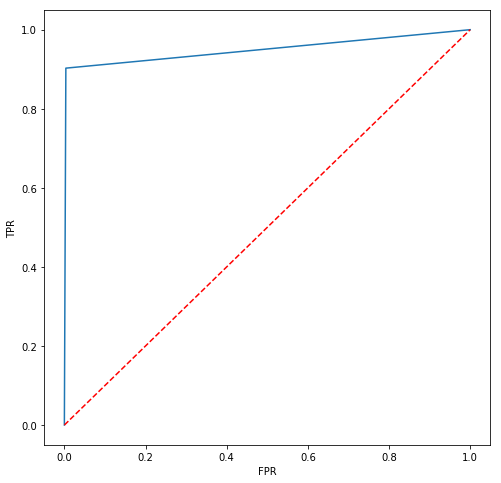

In [48]:
X=[0,FPR,1]
Y=[0,RC1,1]
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(X,Y)
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

From the look of it the predictor is almost perfect and maximizes AUC. However, we have a problem with serious class imbalance, which means that ROC curve is not the best method to measure binary classifier's performance. From confusion matrix, we see that our precision is rather small despite rather low false positive and false negative rates. Precision-recall curve might better represent the problem.

Text(0, 0.5, 'Precision')

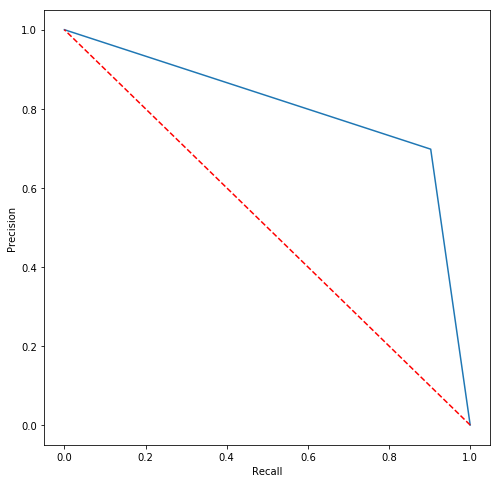

In [49]:
X=[0,RC1,1]
Y=[1,PR1,0]
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(X,Y)
ax.plot([1,0],[0,1],'r--')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

Similarily, accuracy shown before might not be a good measure. Instead, we could use balanced accuracy defined as average of true positive rate and true negative rate. 

In [42]:
BACC=(RC0+RC1)/2
print('Balanced Accuracy: {:.2f} %'.format(100*BACC))

Balanced Accuracy: 94.40 %


We can also look at the F-scores, although they also provide a rather useless information for imbalanced classes.

In [45]:
F1_1=2*PR1*RC1/(RC1+PR1)
print('F1-score for class 1: {:.4f}'.format(F1_1))

F1-score for class 1: 0.7871


However, the Matthews correlation coefficient should not suffer from the same problems.

In [46]:
MCC=(TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
print('Matthews correlation coefficient: {:.4f}'.format(MCC))

Matthews correlation coefficient: 0.7851
